## iPyLeaflet
[ipyleaflet](https://github.com/ellisonbg/ipyleaflet) is a bridge between jupyter notebooks and the [leaflet](http://leafletjs.com/)  javascript library for drawing maps.

ipyleaflet comes with a few examples notebooks (this notebook was derived from one) but very little documentation,
for more documentation read the [Leaflet IPA](http://leafletjs.com/reference.html)

For installation directions, see the README on [ipyleaflet](https://github.com/ellisonbg/ipyleaflet)

In [1]:
from ipyleaflet import (
    Map,
    Marker,
    TileLayer, ImageOverlay,
    Polyline, Polygon, Rectangle, Circle, CircleMarker,
    GeoJSON,
    DrawControl
)

## Visualizing the distribution of the observations

## Load the required libraries

In [2]:
import pandas as pd
import numpy as np
import sklearn as sk
import urllib
import math

In [3]:
import findspark
findspark.init()

from pyspark import SparkContext
#sc.stop()
sc = SparkContext(master="local[3]",pyFiles=['lib/numpy_pack.py','lib/computeStats.py'])

from pyspark import SparkContext
from pyspark.sql import *
sqlContext = SQLContext(sc)

In [4]:
import sys
sys.path.append('./lib')

import numpy as np
from numpy_pack import packArray,unpackArray
from computeStats import computeOverAllDist, STAT_Descriptions

In [5]:
### Read the data frame from pickle file

data_dir='../../Data/Weather'
file_index='SBSBBSSB'
meas='SNWD'

from pickle import load

#read statistics
filename=data_dir+'/STAT_%s.pickle'%file_index
STAT,STAT_Descriptions = load(open(filename,'rb'))
print('keys from STAT=',STAT.keys())

#!ls -ld $data_dir/*.parquet

#read data
filename=data_dir+'/decon_%s_%s.parquet'%(file_index,meas)

df=sqlContext.read.parquet(filename)
print(df.count())
df.show(2)

('keys from STAT=', ['TMIN', 'TOBS', 'TMAX', 'SNOW', 'SNWD', 'PRCP'])
640
+------------------+-------------------+-------------------+---------+--------+--------+---------+-----------+------------------+-------------------+-------------------+------------------+-----------+-----------+------+--------------------+------+
|           coeff_1|            coeff_2|            coeff_3|elevation|   label|latitude|longitude|measurement|             res_1|              res_2|              res_3|          res_mean|    station|  total_var|undefs|              vector|  year|
+------------------+-------------------+-------------------+---------+--------+--------+---------+-----------+------------------+-------------------+-------------------+------------------+-----------+-----------+------+--------------------+------+
|-7675.920202758327|-1713.7803484731985|-1879.7681184974895|    975.4|SBSBBSSB| 46.6311|-115.8086|       SNWD|0.1295505270945476|0.08615954430969164|0.03395396789904623|0.85088578865

In [6]:
#extract longitude and latitude for each station
feature='coeff_1'
sqlContext.registerDataFrameAsTable(df,'weather')
Query="SELECT station, latitude,longitude,elevation,coeff_1,coeff_2 FROM weather"
#Query="SELECT station, latitude,longitude,elevation,%s FROM weather"%feature
print(Query)
df1 = sqlContext.sql(Query)
df1.show(4)

SELECT station, latitude,longitude,elevation,coeff_1,coeff_2 FROM weather
+-----------+--------+---------+---------+------------------+-------------------+
|    station|latitude|longitude|elevation|           coeff_1|            coeff_2|
+-----------+--------+---------+---------+------------------+-------------------+
|USC00104150| 46.6311|-115.8086|    975.4|-7675.920202758327|-1713.7803484731985|
|USC00102892| 46.7744|-116.1761|    889.4|-6762.565109969205|-401.78760835189564|
|USC00102892| 46.7744|-116.1761|    889.4| -9553.40160377961|-63.162574739109374|
|USC00107046| 46.4922|-115.8006|    938.8|-6236.251223956948| 29.739189153140156|
+-----------+--------+---------+---------+------------------+-------------------+
only showing top 4 rows



In [7]:
df2=df1.groupby(['station','latitude','longitude','elevation']).agg({"station": "count", "coeff_1": "mean","coeff_2": "mean"})
pdf=df2.toPandas()
pdf.sort_values(by=['station'],inplace=True)
pdf.head(2)

,station,latitude,longitude,elevation,count(station),avg(coeff_1),avg(coeff_2)
4,US1IDLT0001,46.7544,-117.0005,823.0,1,668.374467,319.019229
25,USC00100528,47.2533,-115.9203,729.7,13,-2482.806680,-6.040403


In [9]:
#define a mapping from the range of the value to hex colors.
from matplotlib.colors import rgb2hex
_avg1='avg(coeff_1)'
_avg2='avg(coeff_2)'
#_avg='avg(%s)'%feature
#_min=pdf[_avg].min()

#_max=pdf[_avg].max()
#print _min,_max
_min = -1000
_max = 1000
import pylab as plt
cmap=plt.get_cmap('jet')
def get_color(val):
    x=(val-_min)/(_max-_min)
    return(rgb2hex(cmap(x)[:3]))
get_color(1000.)

u'#800000'

## Map

In [10]:
#min_lat,max_lat,min_long,max_long = box = (42.1103, 42.6167, -72.6, -70.8)
min_lat = pdf['latitude'].min()
max_lat = pdf['latitude'].max()
min_long = pdf['longitude'].min()
max_long = pdf['longitude'].max()

In [11]:
print min_lat,max_lat,min_long,max_long

46.2325 47.3111 -119.3192 -115.8006


In [18]:
center = [(min_lat+max_lat)/2, (min_long+max_long)/2]
zoom = 9

m = Map(default_tiles=TileLayer(opacity=1.0), center=center, zoom=zoom)

r = Rectangle(bounds=[[min_lat,min_long],[max_lat,max_long]], weight=5, fill_opacity=0.0)
m += r

lat_margin=(max_lat-min_lat)/4
long_margin=(max_long-min_long)/4
circles = []
for index,row in pdf.iterrows():
    _lat=row['latitude']
    _long=row['longitude']
    _count=row['count(station)']
    #_coef=row[_avg]
    _coef=-row[_avg1]
    # taking sqrt of count so that the  area of the circle corresponds to the count
    c = Circle(location=(_lat,_long), radius=int(700*np.sqrt(_count+0.0)), weight=1,
            color='#F00', opacity=0.8, fill_opacity=0.4,
            fill_color=get_color(_coef))
    circles.append(c)
    m.add_layer(c)
m    

In [19]:
_min = -1000
_max = 1000

center = [(min_lat+max_lat)/2, (min_long+max_long)/2]
zoom = 9

m = Map(default_tiles=TileLayer(opacity=1.0), center=center, zoom=zoom)

r = Rectangle(bounds=[[min_lat,min_long],[max_lat,max_long]], weight=5, fill_opacity=0.0)
m += r

lat_margin=(max_lat-min_lat)/4
long_margin=(max_long-min_long)/4
circles = []
for index,row in pdf.iterrows():
    _lat=row['latitude']
    _long=row['longitude']
    _count=row['count(station)']
    #_coef=row[_avg]
    _coef=-row[_avg1]
    # taking sqrt of count so that the  area of the circle corresponds to the count
    c = Circle(location=(_lat,_long), radius=int(700*np.sqrt(_count+0.0)), weight=1,
            color='#F00', opacity=0.8, fill_opacity=0.4,
            fill_color=get_color(_coef))
    circles.append(c)
    m.add_layer(c)
m  

### excercises:
* Add a legend that relates the colors to values.
* Leaflet supports a variety of maps. See if you can get a topographical map as the background.

NameError: name 'set_ylabel' is not defined

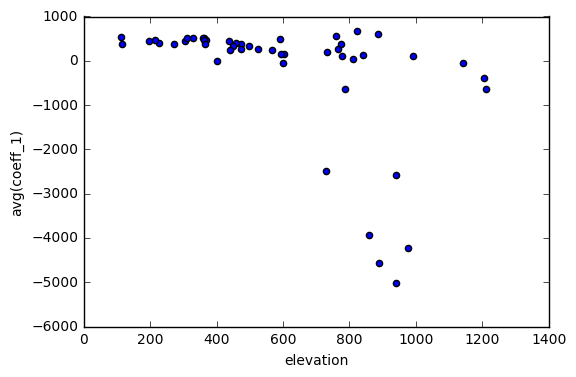

In [27]:
%matplotlib inline
pdf.plot.scatter(x='elevation',y='avg(coeff_1)')
set_ylabel('|coeff_1|')


In [ ]:
RDD1=sc.parallelize(["spark  basics", "spark big  data analysis", "spring"]) 
RDD2=sc.parallelize(["spark using pyspark", "big data"])
 
RDD1.subtract(RDD2).collect()